Author: Nicolas Legrand <nicolas.legrand@cfin.au.dk>

# Hidden Markov Models for M/EEG analysis.

In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from hmmlearn import hmm
from get_simulation import get_simulation

## Single channel simulation

Here, we reproduce the simulation and testing procedure described in [1]. Transient bursting events at 25 and 40 Hz are incorporate into a noisy time serie.

In [2]:
sfreq, seconds = 256, 10
x = get_simulation('long', sfreq=sfreq, seconds=seconds)
time = np.arange(0, len(x[0, :])/256, 1/256)

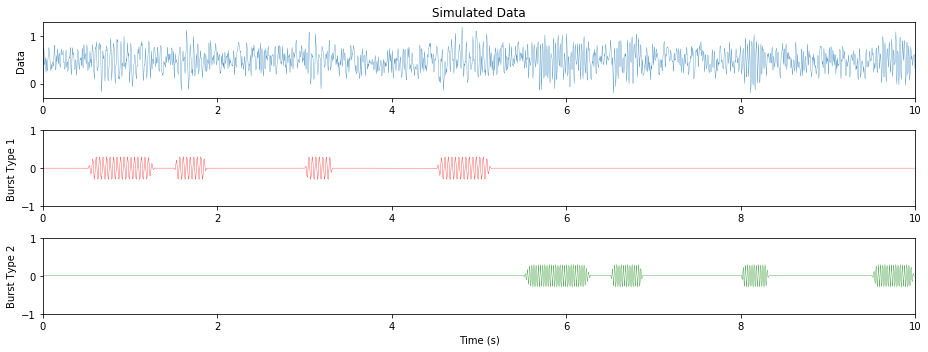

In [3]:
plt.figure(figsize=(13, 5))
plt.subplot(311)
plt.title('Simulated time-course')
plt.plot(time, x[0, :], linewidth=.3)
plt.ylabel('Data')
plt.xlim(0, 10)

plt.subplot(312)
plt.plot(time, x[1, :], 'r', linewidth=.3)
plt.ylim([-1, 1])
plt.ylabel('Burst Type 1')
plt.xlim(0, 10)

plt.subplot(313)
plt.plot(time, x[2, :], 'g', linewidth=.3)
plt.ylim([-1, 1])
plt.ylabel('Burst Type 2')
plt.xlabel('Time (s)')
plt.xlim(0, 10)
plt.tight_layout()

# Burst detection

2 methods are proposed to detect the high frequency burst:
* The amplitude threshold method. After filtering the recording at a specified frequency, the envelope is used to detect bursts events based on an arbitrary threshold as proposed by [2] (here fixed as 2 * the median value).
* The envelope is used to fit a 2 states Hidden Markov Model and predict the probability of each state across time.

In [4]:
# Band-pass filter data (20-30 Hz) 
sos = signal.butter(5, [20, 30], 'bandpass', fs=256, output='sos')
filtered = signal.sosfilt(sos, x[0, :])

## Narrow-band amplitude

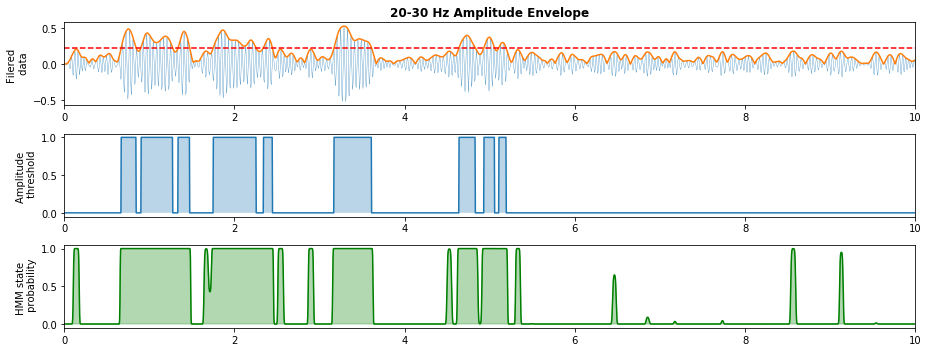

In [5]:
fig = plt.figure(figsize=(13, 5))
plt.subplot(311)
plt.title('20-30 Hz Amplitude Envelope', fontweight='bold')
plt.plot(time, filtered, label='signal', linewidth=.3)

analytic_signal = signal.hilbert(filtered)
amplitude_envelope = np.abs(analytic_signal)
plt.plot(time, amplitude_envelope, label='envelope')
plt.ylabel('Filered \n data')
plt.xlim(0, seconds)

# Here we generate an amplitude threshold using the Shin 2018 method
threshold = 2*np.median(amplitude_envelope)
plt.axhline(y=threshold, linestyle='--', color='r')

plt.subplot(312)
plt.plot(time, amplitude_envelope>threshold)
plt.fill_between(x=time, y1=amplitude_envelope>threshold, alpha=0.3)
plt.ylabel('Amplitude \n threshold')
plt.xlim(0, seconds)

# HHM estimation
remodel = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=100)
remodel.fit(amplitude_envelope.reshape(-1, 1))
proba = remodel.predict_proba(amplitude_envelope.reshape(-1, 1))

plt.subplot(313)
plt.plot(time, proba[:, 1], 'g')
plt.fill_between(x=time, y1=proba[:, 1], alpha=0.3, color='g')
plt.ylabel('HMM state \n probability')
plt.xlim(0, seconds)
plt.tight_layout()

## Wider band amplitude

In [6]:
# Band-pass filter data (20-45 Hz) 
sos = signal.butter(5, [20, 45], 'bandpass', fs=256, output='sos')
filtered = signal.sosfilt(sos, x[0, :])

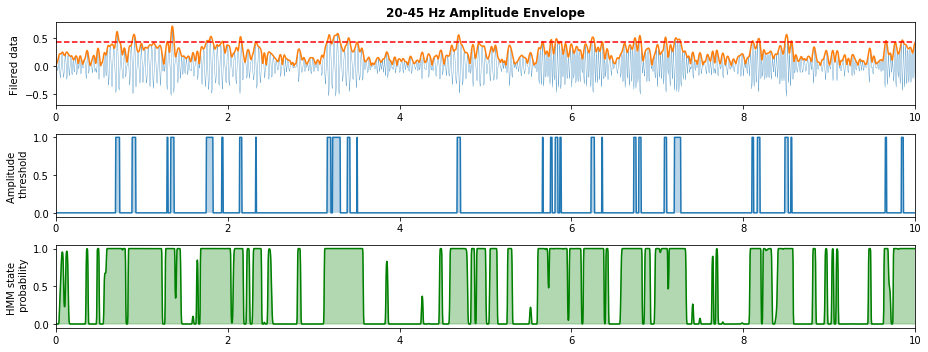

In [7]:
fig = plt.figure(figsize=(13, 5))
plt.subplot(311)
plt.title('20-45 Hz Amplitude Envelope', fontweight='bold')
plt.plot(time, filtered, label='signal', linewidth=.3)

analytic_signal = signal.hilbert(filtered)
amplitude_envelope = np.abs(analytic_signal)
plt.plot(time, amplitude_envelope, label='envelope')
plt.ylabel('Filered data')
plt.xlim(0, seconds)

# Here we generate an amplitude threshold using the Shin 2018 method
threshold = 2*np.median(amplitude_envelope)
plt.axhline(y=threshold, linestyle='--', color='r')

plt.subplot(312)
plt.plot(time, amplitude_envelope>threshold)
plt.fill_between(x=time, y1=amplitude_envelope>threshold, alpha=0.3)
plt.ylabel('Amplitude \n threshold')
plt.xlim(0, seconds)

# HHM estimation
remodel = hmm.GaussianHMM(n_components=2, n_iter=100)
remodel.fit(amplitude_envelope.reshape(-1, 1))
proba = remodel.predict_proba(amplitude_envelope.reshape(-1, 1))

plt.subplot(313)
plt.plot(time, proba[:, 1], 'g')
plt.fill_between(x=time, y1=proba[:, 1], alpha=0.3, color='g')
plt.ylabel('HMM state \n probability')
plt.xlim(0, seconds)
plt.tight_layout()
plt.savefig('WiderBand.png', dpi=600)

# References

[1] Quinn, A. J., van Ede, F., Brookes, M. J., Heideman, S. G., Nowak, M., Seedat, Z. A., … Woolrich, M. W. (2019). Unpacking Transient Event Dynamics in Electrophysiological Power Spectra. Brain Topography, 32(6), 1020–1034. https://doi.org/10.1007/s10548-019-00745-5

[2] Shin, H., Law, R., Tsutsui, S., Moore, C. I., & Jones, S. R. (2017). The rate of transient beta frequency events predicts behavior across tasks and species. eLife, 6. https://doi.org/10.7554/elife.29086